<a href="https://colab.research.google.com/github/abmmatthew/dashboards/blob/master/Homework_4_Transporation_mode_choice_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transportation planning and assessments are important aspects of modeling urban systems and are critical in making key decisions and shaping/estimating the commute behavior of urban population.

Here we demonstrate a framework for transporation mode choice modeling using Bayesian inference. Essentially, we want to model commute across the city by estimating mode choices between origin-destination taxi zone pairs in New York City among 4 available modes - transit, taxi, walking and driving.

In [4]:
# recommended in work in python 3.8
import pandas as pd
import numpy as np
from numpy import inf
from scipy.stats import norm
import itertools
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline



We use data from primarily two sources:

    the travel duration and fare cost for taxi, transit and driving modes are extracted from Google Maps API for each of the origin-destination taxi zone pairs. Cost for walking is kept as 0.
    the mobility information and aggregated income information is retrieved from LEHD data along with ACS for origin-destination commute choice information, further aggregated on taxi zone levels.

The combined data thus contains travel time, travel cost and aggregated commuter information corresponding to each of O-D pairs and 4 travel modes.

The travel modes (column 'tmode') contains codes for each mode referenced as- 2: transit, 3: taxi, 5: walking, 8: driving


In [5]:
# read the data

path = 'https://raw.githubusercontent.com/CUSP-ADS2024/Data/master/'

data = pd.read_csv(path + 'LEHD_commute.csv')
data['duration'] = data['duration']/60  # convert time to hours
data['ridership'] = data.iloc[:, 5:].sum(axis=1)  ## aggregate the ridership across income groups
data = data[['pulocationid', 'dolocationid', 'tmode', 'duration', 'price', 'ridership']]
data.head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,12.721600,736
1,3,7,3,0.798016,43.157143,0
2,3,18,3,0.254000,12.900000,1748
3,3,18,5,1.084444,0.000000,3174
4,3,18,8,0.268923,7.432000,10879


In [6]:
data.ridership.sum() #Nearly 200 mln trips in total

np.int64(191552556)

In [7]:
# number of unique O-D pairs

len(data[['pulocationid', 'dolocationid']].drop_duplicates())

19152

In [8]:
# unique modes

data.tmode.unique()

array([8, 3, 5, 2])

([<matplotlib.axis.XTick at 0x7a083b67b9d0>,
 [Text(0, 0, 'Transit'),
  Text(1, 0, 'Taxi'),
  Text(2, 0, 'Walking'),
  Text(3, 0, 'Driving')])

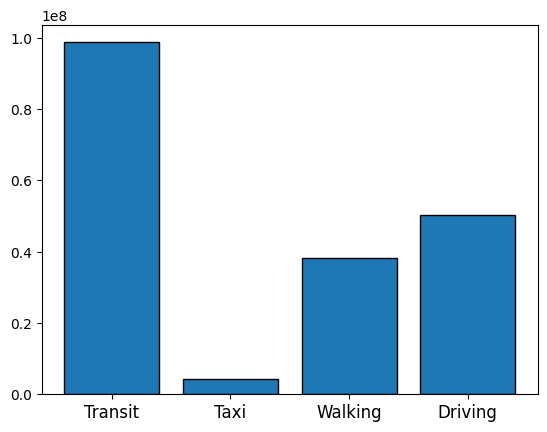

In [9]:
## ridership by mode
byMode = data.groupby(by='tmode', as_index=False).sum()[['tmode', 'ridership']]
plt.bar(np.arange(len(byMode)), list(byMode.ridership), edgecolor = 'black')
plt.xticks([r  for r in range(len(byMode))], ['Transit', 'Taxi',
                                                      'Walking', 'Driving'], fontsize=12)

In [10]:
# choice for constant C - put as median hourly NYC income (assume all agents are rational and value their time as "face value"; in reality its not always the case and one may consider an additional parameter to scale the objective time value to a subjective estimate)
# our study shows this "rationality" parameter could be as low as 10%!
# NYC median income is ~ $33,220 per year

C = 0.1 * 33220/(12 * 180); C

1.537962962962963

In [11]:
data['U'] = - C * data['duration'] - data['price']


TASK 1.

Now assume we know just part of the mobility flows, but not all of them (see training sample defined below). Assess the mobility flows with respect to the transportation mode for the reaming pairs of origin-detination locations


In [12]:
#define total number of commutes per origin - detination pair from the ground-truth data (aggregating all the modes together)
ODflows = data[['pulocationid', 'dolocationid', 'ridership']].groupby(['pulocationid', 'dolocationid']).sum(); ODflows.rename(columns = {'ridership': 'total_commute'}, inplace = True); ODflows.head()

total_commute
pulocationid dolocationid               
3            7                       736
             18                    15801
             20                     8418
             24                     7429
             31                      483

In [14]:
data = data.join(ODflows, on = ['pulocationid', 'dolocationid'])

In [13]:
#define the training set
np.random.seed(1)
train_locations = np.random.choice(np.unique(data['pulocationid']), size = 30, replace = False); train_locations.sort()
train_locations

array([  7,  31,  38,  42,  55,  63,  72,  78,  83,  96, 101, 115, 119,
       131, 186, 189, 191, 195, 197, 199, 223, 227, 229, 236, 237, 240,
       254, 256, 260, 263])

In [15]:
#leave only the flows from training set
train_data = data.loc[data['pulocationid'].isin(train_locations) & data['dolocationid'].isin(train_locations)]
test_data = data.loc[~data['pulocationid'].isin(train_locations) & ~data['dolocationid'].isin(train_locations)]

In [16]:
train_data.head()

,pulocationid,dolocationid,tmode,duration,price,ridership,U,total_commute
533,7,83,8,0.299368,6.849358,5704,-7.309774,13731
534,7,83,5,3.913333,0.000000,713,-6.018562,13731
535,7,83,2,0.516667,2.750000,6808,-3.544614,13731
536,7,83,3,0.348206,12.691395,506,-13.226922,13731
555,7,101,3,0.708611,50.000000,23,-51.089818,2852


In [17]:
test_data.head()

,pulocationid,dolocationid,tmode,duration,price,ridership,U,total_commute
2,3,18,3,0.254000,12.900,1748,-13.290643,15801
3,3,18,5,1.084444,0.000,3174,-1.667835,15801
4,3,18,8,0.268923,7.432,10879,-7.845594,15801
5,3,20,5,1.086389,0.000,299,-1.670826,8418
6,3,20,2,0.600000,2.750,4577,-3.672778,8418


Task 1.1.

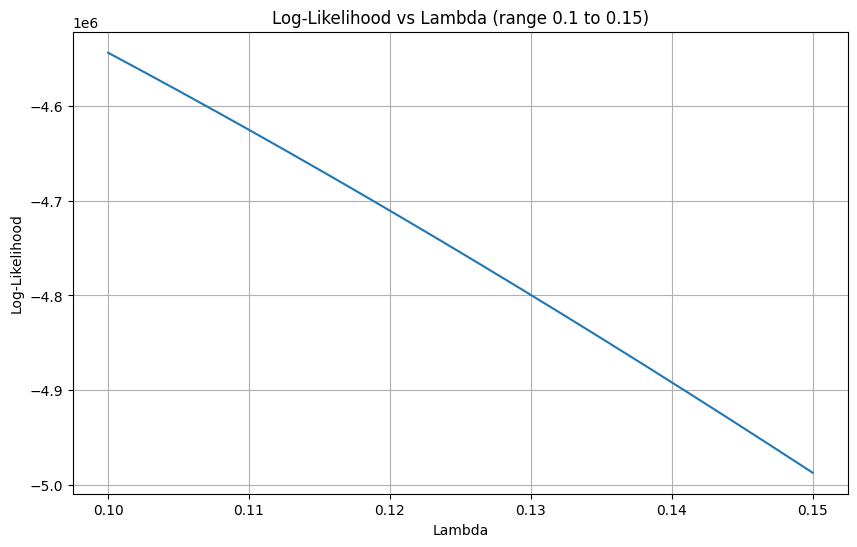

Most likely λ (MAP estimate): 0.10000
Mean λ (weighted): 0.10000
Std λ (weighted): 0.00000
99.9% CI for λ: (0.10000, 0.10000)


In [18]:
# Define updated lambda range
lambdas = np.arange(0.1, 0.15001, 0.00001)

# Prepare U and ridership pivot tables (if not already)
agg_data = train_data.groupby(['pulocationid', 'dolocationid', 'tmode'], as_index=False).agg({
    'U': 'first',
    'ridership': 'sum'
})
pivot = agg_data.pivot_table(index=['pulocationid', 'dolocationid'],
                              columns='tmode',
                              values=['U', 'ridership'],
                              fill_value=0)
U_modes = pivot['U'].values
r_modes = pivot['ridership'].values

log_likelihoods = []

# Compute log-likelihood for each lambda
for lam in lambdas:
    V = lam * U_modes
    exp_V = np.exp(V)
    P = exp_V / exp_V.sum(axis=1, keepdims=True)
    ll = np.sum(r_modes * np.log(P + 1e-12))
    log_likelihoods.append(ll)

# Normalize for relative likelihood
log_likelihoods = np.array(log_likelihoods)
log_likelihoods_shifted = log_likelihoods - log_likelihoods.max()
likelihoods = np.exp(log_likelihoods_shifted)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(lambdas, log_likelihoods)
plt.xlabel("Lambda")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood vs Lambda (range 0.1 to 0.15)")
plt.grid(True)
plt.show()

# MAP estimate
best_lambda = lambdas[np.argmax(log_likelihoods)]
print(f"Most likely λ (MAP estimate): {best_lambda:.5f}")

# Weighted mean, std, and 99.9% CI
lik_sum = likelihoods.sum()
mean_lambda = np.sum(lambdas * likelihoods) / lik_sum
std_lambda = np.sqrt(np.sum((lambdas - mean_lambda)**2 * likelihoods) / lik_sum)
ci_999 = (mean_lambda - 3.29 * std_lambda, mean_lambda + 3.29 * std_lambda)

print(f"Mean λ (weighted): {mean_lambda:.5f}")
print(f"Std λ (weighted): {std_lambda:.5f}")
print(f"99.9% CI for λ: ({ci_999[0]:.5f}, {ci_999[1]:.5f})")


Task 1.2.

In [19]:
import numpy as np # Importing the numpy module with the alias 'np'
# Re-initialize estimation arrays
est_mu = np.zeros(len(test_data))
est_sq = np.zeros(len(test_data))

# Pre-compute likelihood sum
lik_sum = np.sum(likelihoods)

# Run predictions across all lambdas
for lam, lik in zip(lambdas, likelihoods):
    # Compute scaled utility
    test_data['V_tmp'] = lam * test_data['U']
    test_data['expV'] = np.exp(test_data['V_tmp'])

    # Sum of exp(U) per O-D pair
    total_exp = test_data.groupby(['pulocationid', 'dolocationid'])['expV'].transform('sum')

    # Probability of mode = exp(V) / sum(exp(V))
    probs = test_data['expV'] / total_exp

    # Estimate ridership for this λ
    est_riders = test_data['total_commute'] * probs

    # Update weighted sum and squared sum
    est_mu += lik * est_riders
    est_sq += lik * (est_riders ** 2)

# Finalize likelihood-weighted estimates
est_mu /= lik_sum
est_std = np.sqrt(est_sq / lik_sum - est_mu**2)

# Store in test_data
test_data['est_ridership_mu'] = est_mu
test_data['est_ridership_std'] = est_std

# Show first 20 rows with relevant columns
test_data[['pulocationid', 'dolocationid', 'tmode', 'est_ridership_mu', 'est_ridership_std']].head(20)

,pulocationid,dolocationid,tmode,est_ridership_mu,est_ridership_std
2,3,18,3,2668.649825,0.0
3,3,18,5,8532.252386,0.0
4,3,18,8,4600.097788,0.0
5,3,20,5,3488.912979,0.0
6,3,20,2,2855.922848,0.0
7,3,20,8,2073.164174,0.0
8,3,24,2,7429.000000,0.0
11,3,32,2,35330.606653,0.0
12,3,32,3,25372.824648,0.0
13,3,32,5,44866.568699,0.0


Custom Neural Network model for mode-choice probabilities

In [23]:
from scipy.stats import norm
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import numpy as np
import time



simulate sampleN random utility vectors for N modes



In [26]:
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Number of samples to simulate
N = 50000  # 50,000 utility samples

# Simulate utility values for 4 modes (U1 to U4)
# Utilities typically range from negative values due to disutility (e.g., time/cost)
U = np.random.uniform(low=-15, high=0, size=(N, 4))  # shape (50000, 4)

# Preview first few rows
print("Sample utility matrix U (first 5 rows):")
print(U[:5])


Sample utility matrix U (first 5 rows):
[[ -9.38189822  -0.7392854   -4.02009087  -6.02012274]
 [-12.65972039 -12.66008219 -14.12874582  -2.00735781]
 [ -5.98327482  -4.37891133 -14.69123259  -0.45135222]
 [ -2.51336039 -11.81491334 -12.27262549 -12.24893235]
 [-10.43636636  -7.12865353  -8.52082472 -10.6315629 ]]


generate a random sample of U's and sigma's for further choice probability simulation and neural network training to model those

In [27]:
# Number of samples (same as before)
N = 50000

# Step 1: Generate utility values U for 4 modes (already done above, but redefining for clarity)
U = np.random.uniform(low=-15, high=0, size=(N, 4))  # shape: (50000, 4)

# Step 2: Generate sigma values for each sample (randomized individual sensitivity)
sigma_vals = np.random.uniform(low=0.5, high=2.0, size=N)  # shape: (50000,)

# Step 3: Add log-normal noise to each utility using sigma
# noise ~ logN(0, σ), so log(noise) ~ N(0, σ)
noise = np.random.lognormal(mean=0, sigma=sigma_vals[:, np.newaxis], size=(N, 4))  # shape: (50000, 4)
U_noisy = U + np.log(noise)  # Add noise to utility

# Step 4: Determine chosen mode (argmax of noisy utility)
choices = np.argmax(U_noisy, axis=1)  # shape: (50000,)

# Step 5: Create one-hot encoded target probabilities (for training)
P_train = np.zeros((N, 4))
P_train[np.arange(N), choices] = 1  # set 1 at the chosen mode

# Step 6: Combine input features: [U1, U2, U3, U4, sigma]
US_train = np.hstack((U, sigma_vals.reshape(-1, 1)))  # shape: (50000, 5)

# Preview
print("Input shape (US_train):", US_train.shape)
print("Target shape (P_train):", P_train.shape)


Input shape (US_train): (50000, 5)
Target shape (P_train): (50000, 4)


function simulated choices probabilities

In [28]:
import numpy as np

def simulate_choice_probabilities(U, sigma_vals, num_samples=100):
    """
    Simulate choice probabilities using noisy utility model.

    Parameters:
    - U: numpy array of shape (N, 4), base utilities for 4 modes
    - sigma_vals: numpy array of shape (N,), noise level for each sample
    - num_samples: how many times to sample noise per utility vector (default=100)

    Returns:
    - probs: numpy array of shape (N, 4), estimated choice probabilities for each mode
    """
    N = U.shape[0]
    M = U.shape[1]  # Number of modes
    counts = np.zeros((N, M))

    for i in range(num_samples):
        # Simulate log-normal noise per sample
        noise = np.random.lognormal(mean=0, sigma=sigma_vals[:, np.newaxis], size=(N, M))
        noisy_util = U + np.log(noise)

        # Get chosen mode (argmax)
        choices = np.argmax(noisy_util, axis=1)

        # Tally choices
        counts[np.arange(N), choices] += 1

    # Normalize counts to get probabilities
    probs = counts / num_samples
    return probs


In [29]:
# Simulate choice probabilities for the first 10 samples
U_sample = US_train[:10, :4]           # utilities only
sigma_sample = US_train[:10, 4]        # corresponding sigmas

probs_simulated = simulate_choice_probabilities(U_sample, sigma_sample, num_samples=500)
print("Simulated mode choice probabilities (first 10 rows):")
print(np.round(probs_simulated, 3))


Simulated mode choice probabilities (first 10 rows):
[[0.06  0.502 0.006 0.432]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.032 0.196 0.03  0.742]
 [0.464 0.536 0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.016 0.    0.604 0.38 ]
 [0.564 0.006 0.016 0.414]
 [0.014 0.028 0.956 0.002]]



Assess the choice probabilities over 10.000 chunks of the training set of U's and sigma's



In [30]:
# Break 50,000 samples into 5 chunks of 10,000
chunk_size = 10000
num_chunks = US_train.shape[0] // chunk_size

# Store the simulated probabilities for all chunks
simulated_probs = np.zeros_like(P_train)  # shape: (50000, 4)

for i in range(num_chunks):
    start = i * chunk_size
    end = (i + 1) * chunk_size

    U_chunk = US_train[start:end, :4]     # utility part
    sigma_chunk = US_train[start:end, 4]  # sigma part

    # Simulate choice probabilities for this chunk
    probs_chunk = simulate_choice_probabilities(U_chunk, sigma_chunk, num_samples=300)

    # Store results
    simulated_probs[start:end, :] = probs_chunk

print("Finished simulating mode choice probabilities for all 50,000 samples.")


Finished simulating mode choice probabilities for all 50,000 samples.


In [31]:
from sklearn.metrics import mean_squared_error
from scipy.special import kl_div

mse = mean_squared_error(P_train, simulated_probs)
kl = np.mean(np.sum(P_train * np.log((P_train + 1e-12) / (simulated_probs + 1e-12)), axis=1))

print(f"Simulated Probabilities — MSE vs True: {mse:.6f}")
print(f"Simulated Probabilities — KL Divergence vs True: {kl:.6f}")

Simulated Probabilities — MSE vs True: 0.055340
Simulated Probabilities — KL Divergence vs True: 0.378695



Task 2.1 (extracredit)

Given this training data above (array of simulated utilities and sigmas US_train and the corresponding choice probabilities P_train) train a Neural Network Model with an input layer of 5 neurons (receiving utilities U1,2,3,4 and sigma), 3 hidden layers 10 neurons each, softmax output layer with 4 neurons representing 4 mode choice probabilities, adam optimizer, kullback_leibler_divergence opjective function, 100 epochs, batches of size 100). You may use keras or pytorch.

Apply the model to the test set, compare its output with actual probabilities for the first 10 rows of the training set. Compute the overall KL_divergence and MSE


In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the neural network model
model = Sequential([
    Dense(10, activation='relu', input_shape=(5,)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(4, activation='softmax')
])

# Compile model using correct KL divergence loss identifier
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='kl_divergence',  # ← FIXED loss name
              metrics=['accuracy'])

# Train the model using simulated choice probabilities
history = model.fit(US_train, simulated_probs, epochs=100, batch_size=100, verbose=1)

# Predict on the first 10 rows of training data
US_test_10 = US_train[:10]
P_true_10 = simulated_probs[:10]
P_pred_10 = model.predict(US_test_10, verbose=0)

# Print comparison
print("\nTrue Probabilities (Simulated):")
print(np.round(P_true_10, 3))

print("\nPredicted Probabilities (NN):")
print(np.round(P_pred_10, 3))

# Predict on entire training set
P_pred_full = model.predict(US_train, verbose=0)

# Compute evaluation metrics
mse = mean_squared_error(simulated_probs, P_pred_full)
kl_div = np.mean(np.sum(simulated_probs * np.log((simulated_probs + 1e-12) / (P_pred_full + 1e-12)), axis=1))

print(f"\n MSE (full training set): {mse:.6f}")
print(f" KL Divergence (full training set): {kl_div:.6f}")


Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4494 - loss: 0.8621
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9541 - loss: 0.0448
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9738 - loss: 0.0276
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9769 - loss: 0.0263
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9790 - loss: 0.0255
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9786 - loss: 0.0250
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9778 - loss: 0.0247
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9785 - loss: 0.0241
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9782 - loss: 0.0241
Epoch 10/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9772 - loss: 0.0239
Epoch 11/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9775 - loss: 0.0242
Epoch 12/100
500/500 ━━━━━━━━━━━━━━━━━━━━


Task 2.2(extracredit).

Apply the model to training data from the task 1 for sigma = 1


In [35]:
# From Task 1: get utility scores from train_data
train_pivot = train_data.pivot_table(index=['pulocationid', 'dolocationid'],
                                     columns='tmode',
                                     values='U',
                                     fill_value=-999)  # fill missing modes

# Ensure all modes are present: 2, 3, 5, 8
# Fill in missing columns
for mode in [2, 3, 5, 8]:
    if mode not in train_pivot.columns:
        train_pivot[mode] = -999

# Sort by mode code for consistent order
train_pivot = train_pivot[[2, 3, 5, 8]]  # columns = [Transit, Taxi, Walking, Driving]


In [36]:
# Convert to NumPy and add sigma column
U_nn_input = train_pivot.values
sigma_col = np.ones((U_nn_input.shape[0], 1))
US_nn_input = np.hstack((U_nn_input, sigma_col))  # shape: (N, 5)


In [37]:
# Predict mode choice probabilities
P_pred_task2_2 = model.predict(US_nn_input, verbose=0)

# Display first 10 predictions
print("Predicted mode choice probabilities (σ = 1):")
print(np.round(P_pred_task2_2[:10], 3))


Predicted mode choice probabilities (σ = 1):
[[0.968 0.    0.024 0.008]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.013 0.    0.987]]



Task 2.3 (extracredit)

Try different sigmas (try to pick the proper range). Identify the sigma maximizing the likelihood of the training data. Report it together with likelihood-weighted mean and standard deviation


In [38]:
# Pivot train_data into utility matrix by OD-pair and mode
train_util = train_data.pivot_table(index=['pulocationid', 'dolocationid'],
                                    columns='tmode',
                                    values='U', fill_value=-999)

# Ensure consistent column order: Transit (2), Taxi (3), Walking (5), Driving (8)
for m in [2, 3, 5, 8]:
    if m not in train_util.columns:
        train_util[m] = -999

train_util = train_util[[2, 3, 5, 8]].values


In [39]:
train_riders = train_data.pivot_table(index=['pulocationid', 'dolocationid'],
                                      columns='tmode',
                                      values='ridership', fill_value=0)

# Make sure the columns match the utility matrix order
for m in [2, 3, 5, 8]:
    if m not in train_riders.columns:
        train_riders[m] = 0

train_riders = train_riders[[2, 3, 5, 8]].values


In [40]:
# Define sigma range to test
sigma_range = np.arange(0.1, 3.01, 0.1)
log_likelihoods = []

for sigma in sigma_range:
    sigma_input = np.full((train_util.shape[0], 1), sigma)
    US_input = np.hstack((train_util, sigma_input))

    # Predict probabilities using trained NN
    probs = model.predict(US_input, verbose=0)

    # Avoid log(0)
    probs = np.clip(probs, 1e-12, 1)

    # Log-likelihood calculation
    ll = np.sum(train_riders * np.log(probs))
    log_likelihoods.append(ll)


In [41]:
log_likelihoods = np.array(log_likelihoods)
log_likelihoods -= log_likelihoods.max()  # for numerical stability
likelihoods = np.exp(log_likelihoods)

# Best σ (MAP)
best_sigma = sigma_range[np.argmax(log_likelihoods)]

# Likelihood-weighted mean and std
lik_sum = np.sum(likelihoods)
mean_sigma = np.sum(sigma_range * likelihoods) / lik_sum
std_sigma = np.sqrt(np.sum((sigma_range - mean_sigma)**2 * likelihoods) / lik_sum)

# 99.9% Confidence Interval
ci_999 = (mean_sigma - 3.29 * std_sigma, mean_sigma + 3.29 * std_sigma)

# Print results
print(f" Best-fit σ (MAP): {best_sigma:.2f}")
print(f" Likelihood-weighted Mean σ: {mean_sigma:.4f}")
print(f" Std σ: {std_sigma:.4f}")
print(f" 99.9% CI for σ: ({ci_999[0]:.4f}, {ci_999[1]:.4f})")


 Best-fit σ (MAP): 3.00
 Likelihood-weighted Mean σ: 3.0000
 Std σ: 0.0000
 99.9% CI for σ: (3.0000, 3.0000)


In [42]:
# Get utility matrix for test_data: [U1, U2, U3, U4]
test_util = test_data.pivot_table(index=['pulocationid', 'dolocationid'],
                                  columns='tmode', values='U', fill_value=-999)

# Ensure all mode columns exist in correct order
for m in [2, 3, 5, 8]:
    if m not in test_util.columns:
        test_util[m] = -999

test_util = test_util[[2, 3, 5, 8]].values

In [43]:
# Total commute per OD pair (same across modes)
test_total_commute = test_data.groupby(['pulocationid', 'dolocationid'])['total_commute'].first().values


In [44]:
# Use same sigma range and likelihoods from Task 2.3
sigma_range = np.arange(0.1, 3.01, 0.1)
log_likelihoods = []

# Recompute log-likelihoods on training data (to reuse)
for sigma in sigma_range:
    sigma_input = np.full((train_util.shape[0], 1), sigma)
    US_input = np.hstack((train_util, sigma_input))
    probs = model.predict(US_input, verbose=0)
    probs = np.clip(probs, 1e-12, 1)
    ll = np.sum(train_riders * np.log(probs))
    log_likelihoods.append(ll)

log_likelihoods = np.array(log_likelihoods)
log_likelihoods -= log_likelihoods.max()
likelihoods = np.exp(log_likelihoods)
lik_sum = np.sum(likelihoods)


In [47]:
# Prepare output arrays
est_mu = np.zeros(len(test_data))
est_sq = np.zeros(len(test_data))

# Build OD pair to row index map from test_util (unique OD pairs)
unique_od_pairs = test_data[['pulocationid', 'dolocationid']].drop_duplicates().reset_index(drop=True)
od_to_idx = {(row.pulocationid, row.dolocationid): idx for idx, row in unique_od_pairs.iterrows()}

# Predict for each sigma and accumulate estimates
for sigma, lik in zip(sigma_range, likelihoods):
    sigma_input = np.full((len(unique_od_pairs), 1), sigma)
    US_input = np.hstack((test_util, sigma_input))  # test_util must match unique_od_pairs length

    # Predict mode probabilities
    probs = model.predict(US_input, verbose=0)  # shape: (num unique OD pairs, 4)

for row_idx, row in enumerate(test_data.itertuples(index=False)):
    o, d, mode = row.pulocationid, row.dolocationid, row.tmode
    mode_idx = [2, 3, 5, 8].index(mode)

    if (o, d) in od_to_idx:
        od_idx = od_to_idx[(o, d)]
        p = probs[od_idx, mode_idx]
        est = row.total_commute * p
        est_mu[row_idx] += lik * est
        est_sq[row_idx] += lik * (est ** 2)

In [48]:
est_mu /= np.sum(likelihoods)
est_std = np.sqrt(est_sq / np.sum(likelihoods) - est_mu ** 2)

test_data['est_ridership_mu'] = est_mu
test_data['est_ridership_std'] = est_std

test_data[['pulocationid', 'dolocationid', 'tmode', 'est_ridership_mu', 'est_ridership_std']].head(20)


,pulocationid,dolocationid,tmode,est_ridership_mu,est_ridership_std
2,3,18,3,0.000000e+00,0.000000e+00
3,3,18,5,1.580100e+04,NaN
4,3,18,8,1.981541e-19,NaN
5,3,20,5,8.417999e+03,NaN
6,3,20,2,0.000000e+00,0.000000e+00
7,3,20,8,0.000000e+00,0.000000e+00
8,3,24,2,7.429000e+03,NaN
11,3,32,2,4.005510e-07,8.108827e-11
12,3,32,3,1.044412e+05,1.066284e+01
13,3,32,5,1.128804e+03,NaN
